# Return Evaluation
- return = total_pymnt_inv(LC 수수료 제외) - loan_amount / loan_amount

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


## Return 값 가져와보기
- x축은 method 
- y축은 return

In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
return_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
return_data = pd.read_csv(return_data_path)

In [4]:
return_data.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,revol_util,revol_bal,total_acc,total_pymnt,total_pymnt_inv,loan_amnt,credit_history_years,loan_status
0,504.0,142.0,0.1335,140000.0,7.07,941.0,253.98,670.0,9000.0,10538.0,2946.0,0.673,6054.0,8.0,9142.877884,9142.88,7500.0,12,0
1,689.0,79.0,0.2450,37000.0,34.38,349.0,290.59,690.0,16000.0,9859.0,4211.0,0.568,9089.0,24.0,12570.430000,12570.43,10000.0,6,0
2,739.0,192.0,0.0999,72000.0,10.35,480.0,322.63,680.0,18800.0,10397.0,705.0,0.699,13147.0,22.0,10330.460000,10330.46,10000.0,16,0
3,739.0,236.0,0.0721,72000.0,32.13,481.0,371.68,800.0,140200.0,5541.0,78841.0,0.066,9277.0,50.0,12817.155956,12817.16,12000.0,20,0
4,709.0,155.0,0.0762,90000.0,19.29,283.0,405.10,690.0,53700.0,8023.0,32441.0,0.325,17459.0,46.0,14583.506490,14583.51,13000.0,13,0


In [5]:
return_data[return_data['loan_status'] == 1].head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,revol_util,revol_bal,total_acc,total_pymnt,total_pymnt_inv,loan_amnt,credit_history_years,loan_status
10,499.0,122.0,0.1091,100000.0,17.27,921.0,392.36,670.0,19700.0,3124.0,7411.0,0.523,10311.0,21.0,8991.70,8991.70,12000.0,12,1
12,499.0,95.0,0.0735,60000.0,18.46,342.0,558.68,725.0,28900.0,6175.0,13933.0,0.421,12167.0,9.0,6412.03,6412.03,18000.0,8,1
14,504.0,81.0,0.1240,75000.0,16.58,906.0,852.69,725.0,47500.0,1917.0,36009.0,0.141,6676.0,22.0,6734.00,6734.00,25525.0,11,1
18,519.0,81.0,0.1640,60000.0,15.72,276.0,785.00,670.0,13200.0,3788.0,3683.0,0.663,8753.0,10.0,4680.84,4680.84,32000.0,7,1
20,579.0,112.0,0.1153,38000.0,26.34,846.0,277.12,660.0,9000.0,5176.0,1801.0,0.635,5713.0,10.0,4465.88,4465.88,8400.0,10,1


In [4]:
## Return값이 전부 맞았다고 가정
#loan_status가 0이라고 가정한 것이 전부 맞으면 return = (total_pymnt_inv - loan_amount)
#loan_status가 1이라고 가정한 것이 전부 맞으면 return = 0일까?

# Fully Paid로 예측한 것만 투자
invested_paid = return_data[return_data['loan_status'] == 0].copy()  # 예측이 Fully Paid
invested_default = return_data[return_data['loan_status'] == 1].copy()

# 수익률 계산
invested_paid['return'] = invested_paid['total_pymnt_inv'] - invested_paid['loan_amnt']
invested_default['return'] = invested_default['total_pymnt_inv'] - invested_default['loan_amnt']

In [9]:
invested_paid.describe()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,revol_util,revol_bal,total_acc,total_pymnt,total_pymnt_inv,loan_amnt,credit_history_years,loan_status,return
count,299557.000000,299557.000000,299557.000000,2.995570e+05,299557.000000,299557.000000,299557.000000,299557.000000,2.995570e+05,299557.000000,299557.000000,299557.000000,2.995570e+05,299557.000000,299557.000000,299557.000000,299557.000000,299557.000000,299557.0,299557.000000
mean,705.395250,182.960382,0.125869,7.862520e+04,18.149218,515.865929,432.689255,699.663303,3.473516e+04,14212.533258,11631.554729,0.498591,1.652798e+04,24.632274,16722.454826,16702.143119,14276.162633,16.460847,0.0,2425.980486
std,64.484677,93.857835,0.045880,7.488501e+04,12.411377,311.813273,266.371635,33.619363,4.324779e+04,16961.420835,16685.777026,0.249046,2.396789e+04,11.992250,10841.024047,10840.896048,8923.682879,7.602360,0.0,2757.891534
min,0.000000,3.000000,0.053100,0.000000e+00,0.000000,8.000000,14.770000,660.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.000000,840.474210,0.000000,700.000000,3.000000,0.0,-29022.470000
25%,674.000000,120.000000,0.091600,4.700000e+04,11.540000,235.000000,238.500000,675.000000,1.500000e+04,3295.000000,1841.000000,0.309000,5.806000e+03,16.000000,8390.581399,8369.060000,7300.000000,11.000000,0.0,746.610000
50%,709.000000,170.000000,0.119900,6.500000e+04,17.290000,481.000000,365.910000,690.000000,2.640000e+04,8706.000000,5958.000000,0.498000,1.108500e+04,23.000000,13936.509999,13919.070000,12000.000000,15.000000,0.0,1539.340000
75%,749.000000,229.000000,0.151000,9.500000e+04,23.740000,804.000000,575.890000,715.000000,4.220000e+04,19141.000000,13942.000000,0.691000,1.993300e+04,31.000000,22838.080000,22814.900000,20000.000000,20.000000,0.0,3052.830000
max,850.000000,818.000000,0.309900,1.099920e+07,999.000000,999.000000,1719.830000,845.000000,9.999999e+06,752994.000000,506507.000000,1.777000,2.904836e+06,165.000000,66714.370000,66714.370000,40000.000000,68.000000,0.0,31714.370000


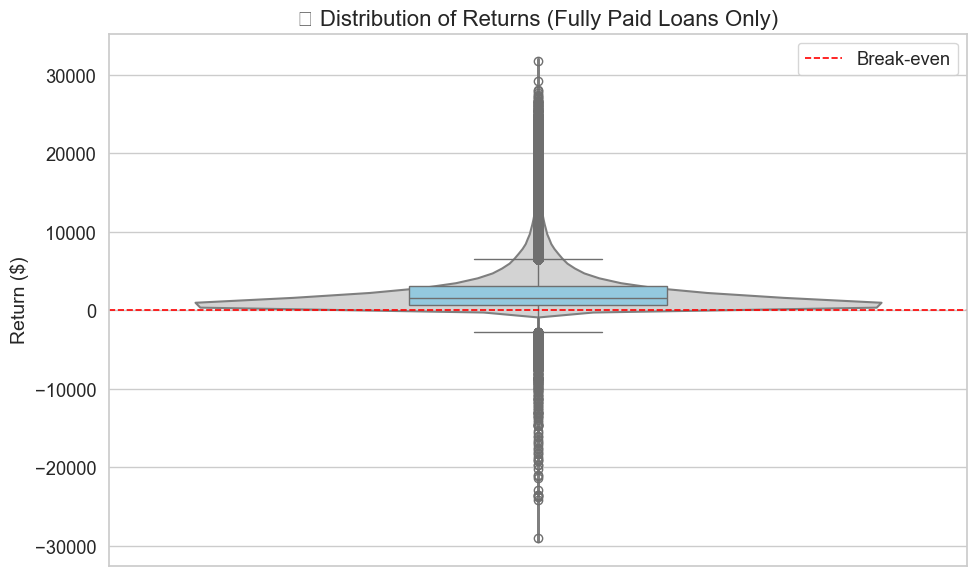

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.boxplot(data=invested_paid, y='return', color='skyblue', width=0.3)
sns.violinplot(data=invested_paid, y='return', inner=None, color='lightgray', linewidth=1.5)

plt.title("📈 Distribution of Returns (Fully Paid Loans Only)", fontsize=16)
plt.ylabel("Return ($)", fontsize=14)
plt.xlabel("")  # x축 레이블 없애기
plt.axhline(0, color='red', linestyle='--', linewidth=1.2, label="Break-even")
plt.legend()
plt.tight_layout()
plt.show()


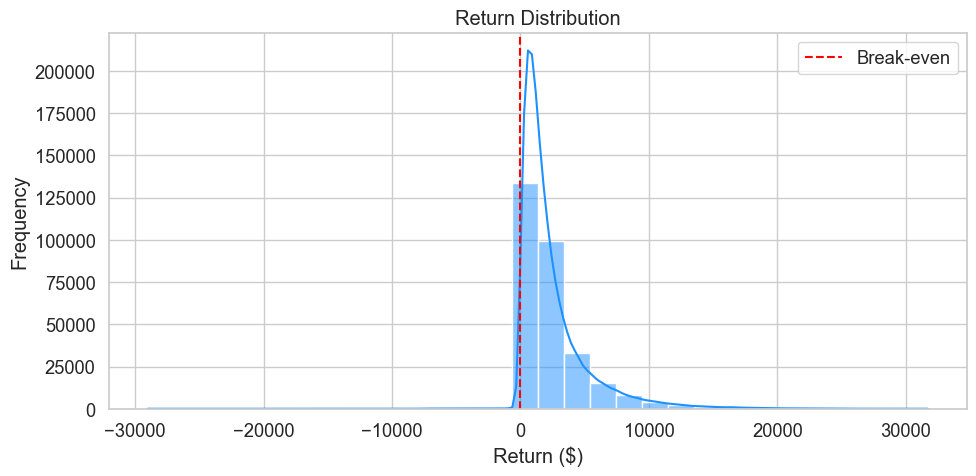

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(invested_paid['return'], kde=True, bins=30, color='dodgerblue')
plt.title("Return Distribution")
plt.xlabel("Return ($)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.legend()
plt.tight_layout()
plt.show()


<Axes: xlabel='log_return', ylabel='Count'>

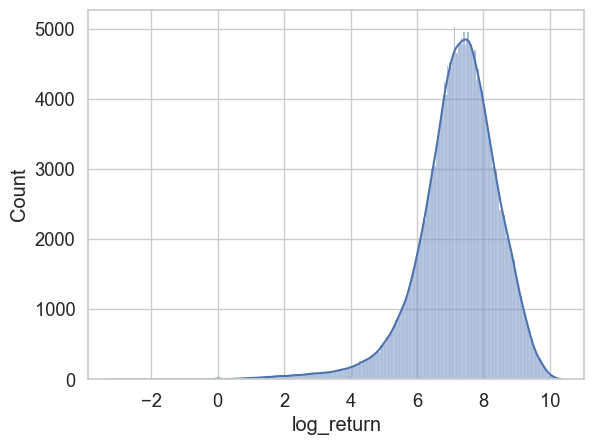

In [ ]:
invested_paid['log_return'] = np.log1p(invested_paid['return'])  # log(1 + r)
sns.histplot(invested_paid['log_return'], kde=True)

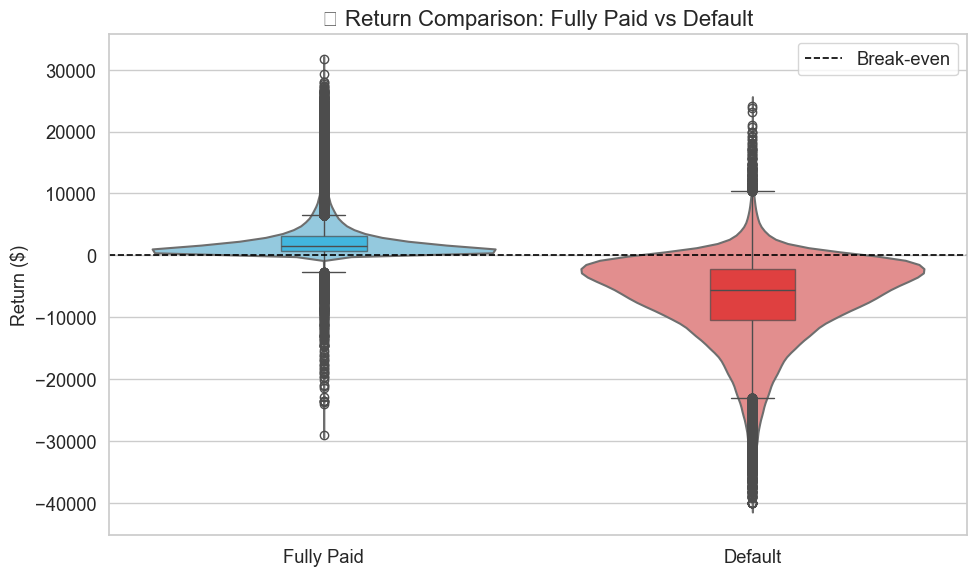

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ 데이터 정리
invested_paid['status'] = 'Fully Paid'
invested_default['status'] = 'Default'

combined = pd.concat([invested_paid, invested_default], ignore_index=True)

# 2️⃣ 시각화 (Boxplot + Violinplot)
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

# Violinplot for distribution shape
sns.violinplot(data=combined, x='status', y='return',
               palette={'Fully Paid': 'skyblue', 'Default': 'lightcoral'},
               inner=None, linewidth=1.5)

# Boxplot inside for median, IQR
sns.boxplot(data=combined, x='status', y='return',
            width=0.2, boxprops=dict(alpha=0.7),
            palette={'Fully Paid': 'deepskyblue', 'Default': 'red'})

# Line for break-even
plt.axhline(0, color='black', linestyle='--', linewidth=1.2, label='Break-even')

plt.title("📈 Return Comparison: Fully Paid vs Default", fontsize=16)
plt.ylabel("Return ($)", fontsize=13)
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.show()


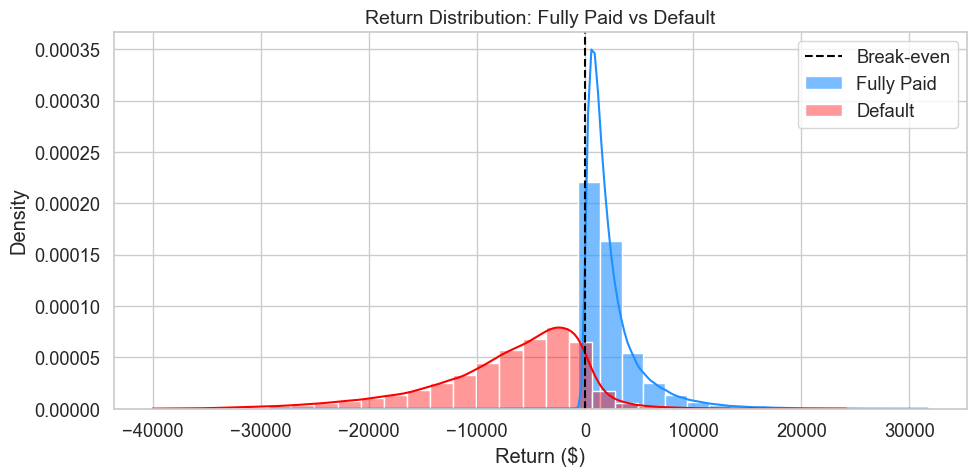

In [13]:
plt.figure(figsize=(10, 5))

# 🔵 Fully Paid
sns.histplot(invested_paid['return'], kde=True, bins=30, color='dodgerblue', label='Fully Paid', stat='density', alpha=0.6)

# 🔴 Default
sns.histplot(invested_default['return'], kde=True, bins=30, color='red', label='Default', stat='density', alpha=0.4)

# 기준선
plt.axvline(0, color='black', linestyle='--', label='Break-even')

# 스타일링
plt.title("Return Distribution: Fully Paid vs Default", fontsize=14)
plt.xlabel("Return ($)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


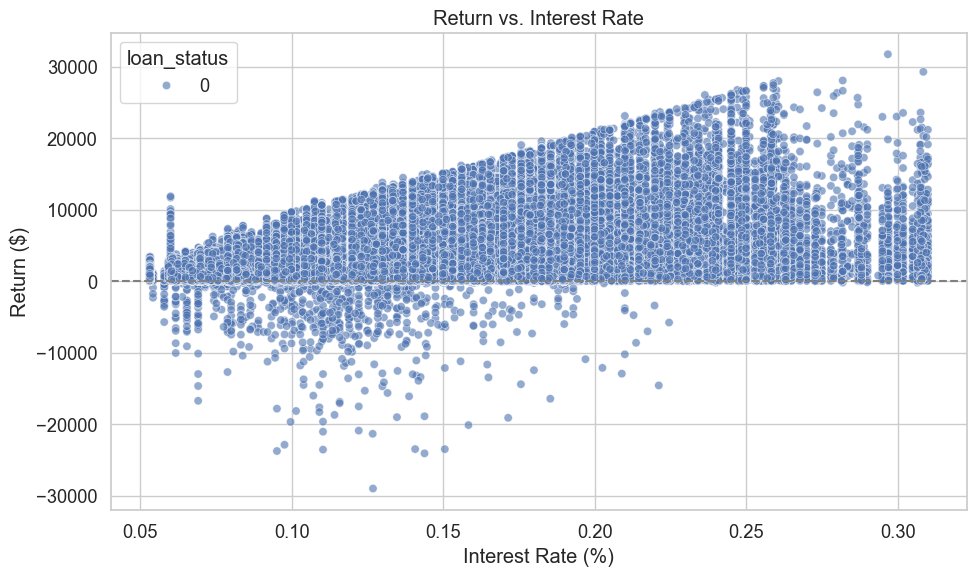

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=invested_paid, x='int_rate', y='return', hue='loan_status', alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.title("Return vs. Interest Rate")
plt.xlabel("Interest Rate (%)")
plt.ylabel("Return ($)")
plt.tight_layout()
plt.show()


In [5]:
# 인덱스를 reset해서 순차적 index 맞추기
invested_paid = invested_paid.reset_index(drop=True)
invested_default = invested_default.reset_index(drop=True)

# invest의 행 수가 맞는 상태로 되어 있어야 함 (같은 순서와 길이일 때만)
invest = pd.DataFrame()
invest['correct_paid'] = invested_paid['return']
invest['correct_default'] = invested_default['return']

In [14]:
invest.head()

,correct_paid,correct_default
0,1642.88,-3008.30
1,2570.43,-11587.97
2,330.46,-18791.00
3,817.16,-27319.16
4,1583.51,-3934.12


## 수익률 구하기

In [37]:
Results = []
loan_amnt = return_data['loan_amnt'].values
total_pymnt_inv = return_data['total_pymnt_inv'].values

def predict_return(model, X_test, y_test, method):
    #y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

    threshold = 0.7
    y_pred = (y_prob >= threshold).astype(int)

    for i in range(len(y_test)):
        pred = y_pred[i]
        true = y_test.iloc[i]
        amt = loan_amnt[i]
        inv = total_pymnt_inv[i]

        # 예측이 Fully Paid → 투자함
        if pred == 0:
            profit = inv - amt
            status = 'Correct' if pred == true else 'Incorrect'
            actual_label = 'Fully Paid' if true == 0 else 'Default'
            prediction_label = 'Fully Paid'

        # 예측이 Default → 투자 안함
        else:
            if true == 0:
                # 기회 손실 (투자 안 했지만 실제로는 수익 가능)
                profit = -(inv-amt)
                status = 'Missed Gain'
            else:
                # 실제도 Default → 옳은 판단 (손익 없음)
                profit = inv-amt
                status = 'Correct'
            actual_label = 'Fully Paid' if true == 0 else 'Default'
            prediction_label = 'Default'

        Results.append({
            'method': method,
            'prediction': prediction_label,
            'actual': actual_label,
            'return': profit,
            'status': status
        })

In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle


def return_evaluation(model, data_x, data_y,X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

    elif method == 'Undersampling':
            X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
            undersampler = RandomUnderSampler(random_state=42)
            X_under, y_under = undersampler.fit_resample(X_train, y_train)

            data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
            X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
            y_train = data_under[['loan_status']]  # Target (타겟 변수)

            model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
            )

    elif method == 'SMOTE':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

        smote = SMOTE(random_state=42)
        # 오버샘플링 수행
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        X_train = augmentation_data.drop(columns='loan_status')
        y_train = augmentation_data[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
    
    elif method == 'table-gan':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)

        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        train_total = pd.concat([train_dataset,fake])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )

    
    predict_return(model, X_test, y_test, method)    



In [39]:
Methods = ['Base', 'Undersampling', 'SMOTE', 'table-gan']

X_test = return_data.drop(columns=['loan_status', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt'])
y_test = return_data['loan_status']

for method in Methods:
    data_x = data.drop(columns='loan_status')
    data_y = data['loan_status']

    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )

    return_evaluation(model, data_x, data_y, X_test, y_test, method)

returns_df = pd.DataFrame(Results)

Preprocessing method : Base
[0]	validation_0-logloss:0.49200	validation_1-logloss:0.49202
[1]	validation_0-logloss:0.48744	validation_1-logloss:0.48748
[2]	validation_0-logloss:0.48300	validation_1-logloss:0.48306
[3]	validation_0-logloss:0.47868	validation_1-logloss:0.47875
[4]	validation_0-logloss:0.47448	validation_1-logloss:0.47456
[5]	validation_0-logloss:0.47038	validation_1-logloss:0.47048
[6]	validation_0-logloss:0.46638	validation_1-logloss:0.46650
[7]	validation_0-logloss:0.46248	validation_1-logloss:0.46261
[8]	validation_0-logloss:0.45867	validation_1-logloss:0.45882
[9]	validation_0-logloss:0.45496	validation_1-logloss:0.45511
[10]	validation_0-logloss:0.45133	validation_1-logloss:0.45149
[11]	validation_0-logloss:0.44778	validation_1-logloss:0.44796
[12]	validation_0-logloss:0.44432	validation_1-logloss:0.44450
[13]	validation_0-logloss:0.44093	validation_1-logloss:0.44113
[14]	validation_0-logloss:0.43761	validation_1-logloss:0.43782
[15]	validation_0-logloss:0.43437	val

In [40]:
returns_df.head()

,method,prediction,actual,return,status
0,Base,Default,Fully Paid,-1642.88,Missed Gain
1,Base,Fully Paid,Fully Paid,2570.43,Correct
2,Base,Fully Paid,Fully Paid,330.46,Correct
3,Base,Fully Paid,Fully Paid,817.16,Correct
4,Base,Fully Paid,Fully Paid,1583.51,Correct


In [41]:
# ✅ 2. test 데이터에서 실제 Fully Paid / Default 분리하여 baseline 수익 계산
# 아래 두 줄은 너의 return_data 기준에서 정의됨
invested_paid = return_data[return_data['loan_status'] == 0].copy()
invested_default = return_data[return_data['loan_status'] == 1].copy()

# ✅ 3. 수익률 계산
invested_paid['return'] = invested_paid['total_pymnt_inv'] - invested_paid['loan_amnt']
invested_default['return'] = invested_default['total_pymnt_inv'] - invested_default['loan_amnt']

# ✅ 4. 메서드/라벨 추가
invested_paid['method'] = 'All Correct'
invested_paid['prediction'] = 'Fully Paid'
invested_paid['actual'] = 'Fully Paid'
invested_paid['status'] = 'Correct'

invested_default['method'] = 'All Correct'
invested_default['prediction'] = 'Default'
invested_default['actual'] = 'Default'
invested_default['status'] = 'Correct'

# ✅ 5. 필요한 컬럼만 선택하고 결합
invested_correct = pd.concat([invested_paid, invested_default], ignore_index=True)
invested_correct = invested_correct[['method', 'prediction', 'actual', 'return', 'status']]

# ✅ 6. returns_df와 결합
returns_df_all = pd.concat([returns_df, invested_correct], ignore_index=True)

In [42]:
returns_df_all.head()

,method,prediction,actual,return,status
0,Base,Default,Fully Paid,-1642.88,Missed Gain
1,Base,Fully Paid,Fully Paid,2570.43,Correct
2,Base,Fully Paid,Fully Paid,330.46,Correct
3,Base,Fully Paid,Fully Paid,817.16,Correct
4,Base,Fully Paid,Fully Paid,1583.51,Correct


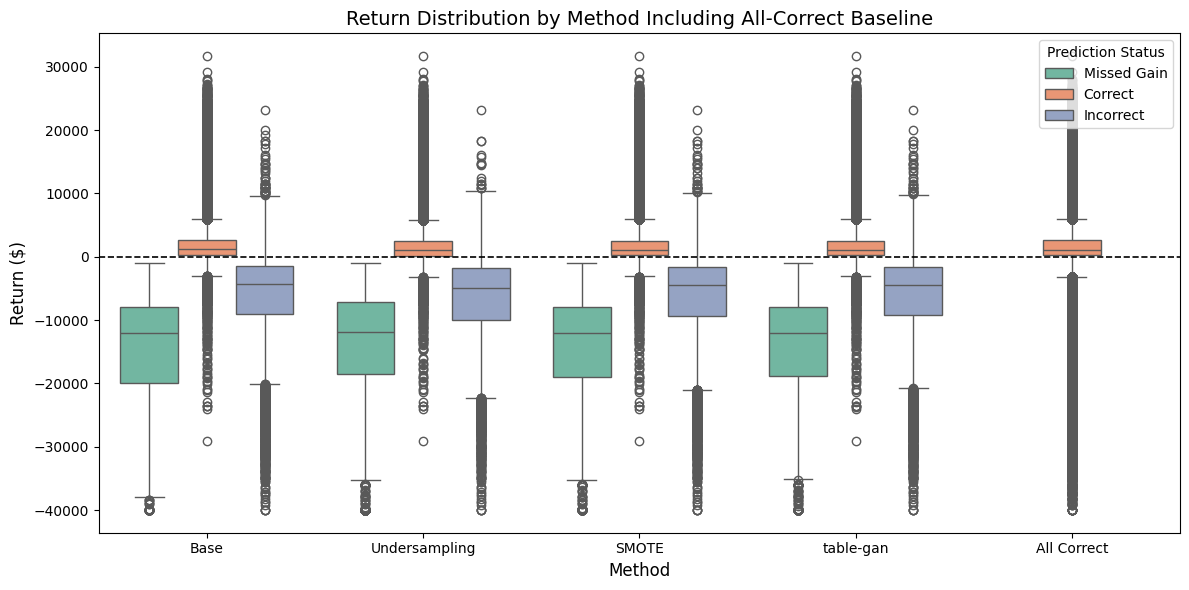

In [23]:
# ✅ 7. 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(data=returns_df_all, x='method', y='return', hue='status', palette='Set2')
plt.axhline(0, linestyle='--', color='black', linewidth=1.2)
plt.title("Return Distribution by Method Including All-Correct Baseline", fontsize=14)
plt.xlabel("Method", fontsize=12)
plt.ylabel("Return ($)", fontsize=12)
plt.legend(title="Prediction Status", loc='upper right')
plt.tight_layout()
plt.show()

In [43]:
import pandas as pd

# ✅ 1. returns_df에는 다음 컬럼이 포함되어 있어야 함:
# 'method', 'prediction', 'actual', 'return'

# ✅ 2. 예측 결과 유형 라벨링 함수
def label_case(row):
    if row['prediction'] == 'Fully Paid' and row['actual'] == 'Fully Paid':
        return 'FP→FP'  # 정답 + 수익
    elif row['prediction'] == 'Fully Paid' and row['actual'] == 'Default':
        return 'FP→DF'  # 오답 + 손실
    elif row['prediction'] == 'Default' and row['actual'] == 'Fully Paid':
        return 'DF→FP'  # 오답 + 기회손실
    elif row['prediction'] == 'Default' and row['actual'] == 'Default':
        return 'DF→DF'  # 정답 + 리스크회피
    else:
        return 'Unknown'

# ✅ 3. 새로운 컬럼 생성
returns_df_all['case'] = returns_df_all.apply(label_case, axis=1)

# ✅ 4. 피벗 테이블 생성
pivot_table = returns_df_all.pivot_table(
    index='method',
    columns='case',
    values='return',
    aggfunc='mean'
).fillna(0).round(2)

# ✅ 5. 보기 좋게 정리
pivot_table.reset_index(inplace=True)
print(pivot_table)

# ✅ 6. 필요 시 CSV 저장
# pivot_table.to_csv("methodwise_return_analysis.csv", index=False)


case         method    DF→DF    DF→FP    FP→DF    FP→FP
0       All Correct -7099.84     0.00     0.00  2425.98
1              Base -8132.37 -3392.18 -6024.16  2398.98
2             SMOTE -7520.24 -3007.77 -6123.80  2390.37
3     Undersampling -7224.06 -2853.81 -6462.95  2381.80
4         table-gan -7427.91 -2857.87 -6234.29  2392.76


In [44]:
pivot_table['Total_return'] = pivot_table[['FP→DF', 'FP→FP']].sum(axis=1)
print(pivot_table)

case         method    DF→DF    DF→FP    FP→DF    FP→FP  Total_return
0       All Correct -7099.84     0.00     0.00  2425.98       2425.98
1              Base -8132.37 -3392.18 -6024.16  2398.98      -3625.18
2             SMOTE -7520.24 -3007.77 -6123.80  2390.37      -3733.43
3     Undersampling -7224.06 -2853.81 -6462.95  2381.80      -4081.15
4         table-gan -7427.91 -2857.87 -6234.29  2392.76      -3841.53


In [ ]:
#pivot_table.to_csv("methodwise_return_analysis.csv", index=False)

In [49]:
# ✅ 1. 필요한 포맷 적용 (정수 or 소수점 2자리 등)
formatted_table = pivot_table.copy()
formatted_table = formatted_table.round(2)

# ✅ 2. LaTeX 표로 변환
latex_code = formatted_table.to_latex(
    index=False,
    caption="Average Return by Method and Prediction Outcome",
    label="tab:method_returns",
    column_format="lrrrrr",  # 1st column left-aligned, others right-aligned
    bold_rows=True,
    longtable=False,
    escape=False
)

# ✅ 3. 출력 or 저장
print(latex_code)

# latex_code를 파일로 저장하고 싶다면:
# with open("method_returns_table.tex", "w") as f:
#     f.write(latex_code)


\begin{table}
\caption{Average Return by Method and Prediction Outcome}
\label{tab:method_returns}
\begin{tabular}{lrrrrr}
\toprule
method & DF→DF & DF→FP & FP→DF & FP→FP & Total_return \\
\midrule
All Correct & -7099.840000 & 0.000000 & 0.000000 & 2425.980000 & 2425.980000 \\
Base & -7429.350000 & -2988.990000 & -6120.840000 & 2387.050000 & -6722.780000 \\
SMOTE & -7249.230000 & -2827.990000 & -6363.370000 & 2383.830000 & -6807.530000 \\
Undersampling & -7125.270000 & -2803.230000 & -6852.600000 & 2365.530000 & -7290.300000 \\
table-gan & -7246.720000 & -2787.420000 & -6369.340000 & 2383.420000 & -6773.340000 \\
\bottomrule
\end{tabular}
\end{table}



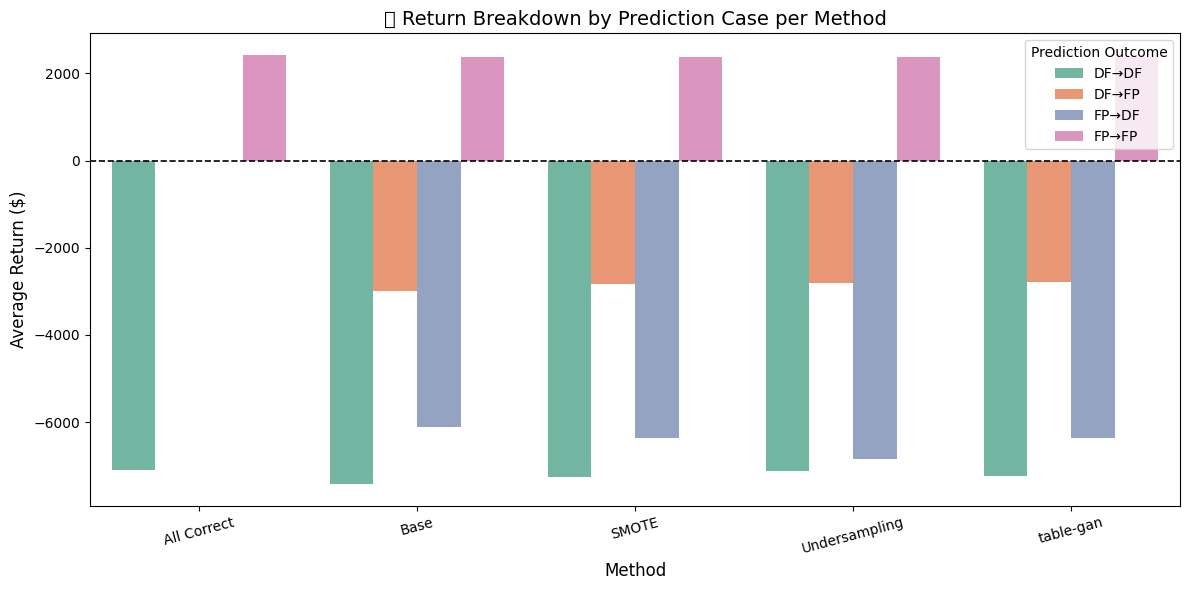

In [50]:
melted = pd.melt(
    pivot_table,
    id_vars='method',
    value_vars=['DF→DF', 'DF→FP', 'FP→DF', 'FP→FP'],
    var_name='Prediction Case',
    value_name='Return'
)

# ✅ Barplot 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='method', y='Return', hue='Prediction Case', palette='Set2')
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.title("📊 Return Breakdown by Prediction Case per Method", fontsize=14)
plt.xlabel("Method", fontsize=12)
plt.ylabel("Average Return ($)", fontsize=12)
plt.xticks(rotation=15)
plt.legend(title="Prediction Outcome")
plt.tight_layout()
plt.show()

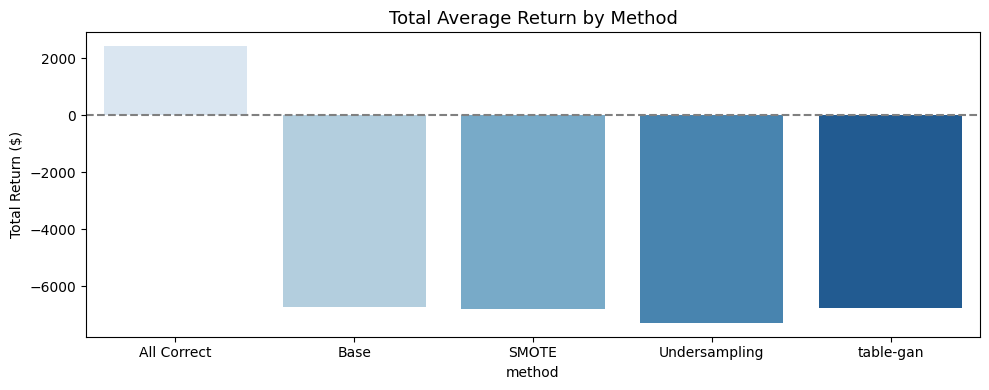

In [51]:
plt.figure(figsize=(10, 4))
sns.barplot(data=pivot_table, x='method', y='Total_return', palette='Blues')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Total Average Return by Method", fontsize=13)
plt.ylabel("Total Return ($)")
plt.tight_layout()
plt.show()
